In [1]:
# import required modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cooltools
import bioframe
import cooler

from cooltools import eigdecomp
from HMMC.HMMC import get_segmentation, _postprocess_seg


In [2]:
# todo: update this with storage location
# specify cooler and fasta storage locations
cooler_file = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
fasta_file='/pollard/data/vertebrate_genomes/human/hg19/hg19/hg19.fa'

In [3]:
# load cooler, obtain bin table
resolution = 50000
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))
chromsizes = c.chromsizes      
bins = c.bins()[:]

In [4]:
# generate binned dataframe of GC content
fasta_records = bioframe.load_fasta(fasta_file)
gc_table = bioframe.genomeops.frac_gc(bins, fasta_records)

In [5]:
# specify regions as autosomes, obtain cis eigenvectors
regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames if (chrom.replace('chr','')).isdigit() ]
cis_val, cis_eig = eigdecomp.cooler_cis_eig(
                c, 
                gc_table,
                regions,
                n_eigs=3, 
                balance=True,
                ignore_diags = 2, clip_percentile=99)
cis_eig = cis_eig.iloc[ np.array([i.isdigit() for i in cis_eig.chrom.str.replace('chr','').values])]

In [6]:
# get segmentation using HMMC
hmm_track = get_segmentation(cis_eig, state_list= ["binary", "HMM2","HMM3", "HMM3P"])

Text(0, 0.5, 'state')

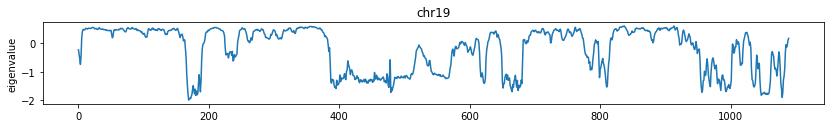

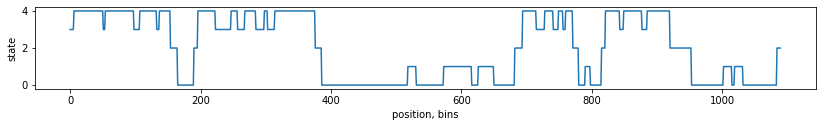

In [7]:
# visualize eigenvector and HMM3P segmentation for chromosome 19
# HMM3P_nums_to_names =  {0:'B', 1:'M_{bb}', 2:'M', 3:'M_{aa}', 4:'A'}
# HMM2_nums_to_names  =  {0:'B', 1:'A'}

plt.figure(figsize=(14, 1.5))
chrom = 'chr19'
mask = (~hmm_track['E1'].isna()) & (hmm_track.chrom == chrom)
y1 = hmm_track[mask]['E1'].values
plt.plot(y1)
plt.ylabel('eigenvalue')
plt.title(chrom)
plt.figure(figsize=(14, 1.5))
y2 = hmm_track[mask]['HMM3P'].values 
plt.plot(y2)
plt.xlabel('position, bins')
plt.ylabel('state')

In [8]:
hmm_track

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,chr1,50000,100000,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,chr1,100000,150000,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,chr1,150000,200000,NaN,0.447314,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,chr1,200000,250000,NaN,0.410796,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57628,chr22,51100000,51150000,0.003032,0.535640,-0.149054,0.512294,0.098943,False,1.0,1.0,2.0
57629,chr22,51150000,51200000,0.003962,0.530300,-0.249122,0.585472,0.268453,False,1.0,1.0,2.0
57630,chr22,51200000,51250000,NaN,0.447179,NaN,NaN,NaN,NaN,NaN,NaN,0.0
57631,chr22,51250000,51300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
